In [15]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

plt.rcParams["image.cmap"] = "gray"

(224, 224)


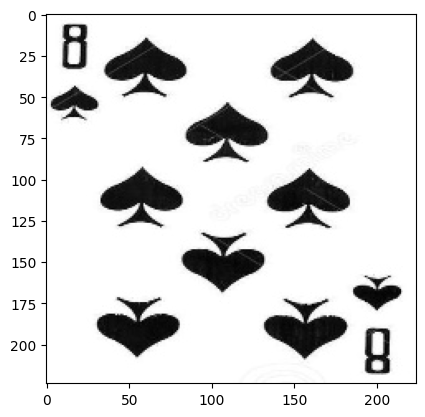

In [2]:
image_path = "../../data/playing_cards/train/eight of spades/005.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img) 

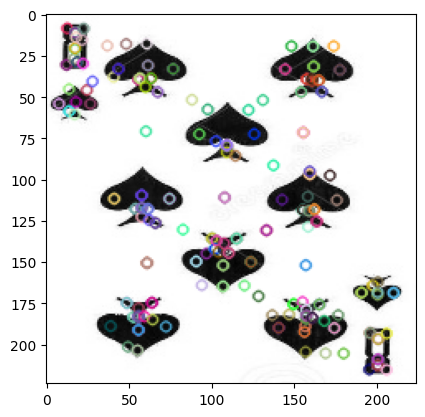

In [3]:
sift = cv2.SIFT.create()
keypoints, descriptors = sift.detectAndCompute(img, None)
img1 = cv2.drawKeypoints(img, keypoints, img)
plt.imshow(img1)

# Feature Matching

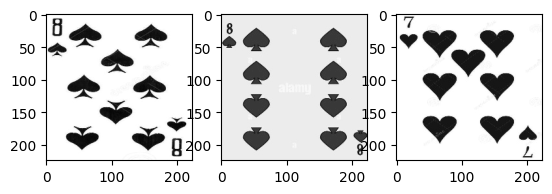

In [4]:
image_path1 = "../../data/playing_cards/train/eight of spades/005.jpg"
image_path2 = "../../data/playing_cards/train/eight of spades/006.jpg"
image_path3 = "../../data/playing_cards/train/seven of hearts/005.jpg"
img1 = cv2.imread(image_path1, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image_path2, cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(image_path3, cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3)

In [5]:
sift = cv2.SIFT().create()

kp1, desc1 = sift.detectAndCompute(img1, None)
kp2, desc2 = sift.detectAndCompute(img2, None)
kp3, desc3 = sift.detectAndCompute(img3, None)

len(kp1), len(kp2), len(kp3)

(222, 110, 80)

Trying out the brute force matcher

30


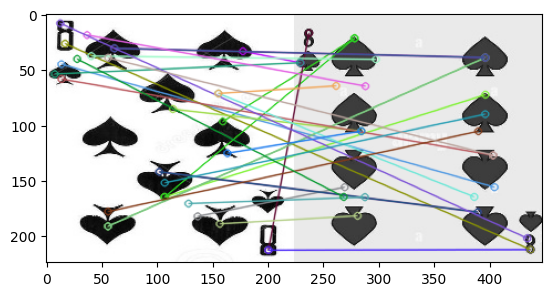

In [9]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(desc1, desc2)
matches = sorted(matches, key=lambda x: x.distance)
print(len(matches))

img12 = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], img2, flags=2)
plt.imshow(img12)

30


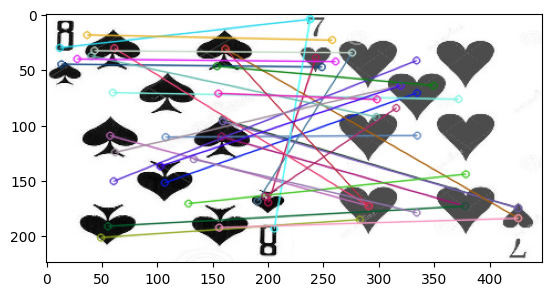

In [8]:
matches = bf.match(desc1, desc3)
matches = sorted(matches, key=lambda x: x.distance)
print(len(matches))

img13 = cv2.drawMatches(img1, kp1, img3, kp3, matches[:50], img3, flags=2)
plt.imshow(img13)

26


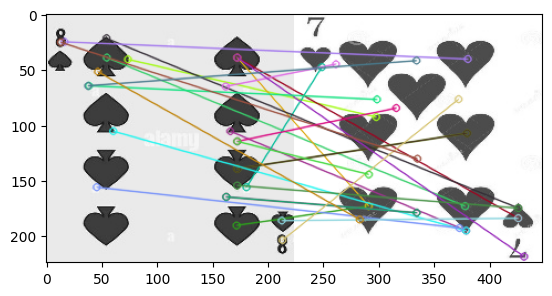

In [10]:
matches = bf.match(desc2, desc3)
matches = sorted(matches, key=lambda x: x.distance)
print(len(matches))

img23 = cv2.drawMatches(img2, kp2, img3, kp3, matches[:50], img3, flags=2)
plt.imshow(img23)

Clustering to create Bag of Visual Words

In [25]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)

desc_list = [desc1, desc2, desc3]

all_desc = np.vstack(desc_list)

kmeans.fit(all_desc)

KMeans(n_clusters=5)

In [32]:
c_inx = kmeans.predict(desc1)
np.histogram(c_inx, bins=np.arange(n_clusters + 1))[0].sum()

222

In [35]:
bovw_histograms = []

for desc in desc_list:
    cluster_indices = kmeans.predict(desc)

    histogram, _ = np.histogram(cluster_indices, bins=np.arange(n_clusters + 1))

    histogram = histogram / np.linalg.norm(histogram)

    bovw_histograms.append(histogram)


bovw_histograms = np.array(bovw_histograms)
bovw_histograms

array([[0.39755269, 0.66905208, 0.35876706, 0.33937424, 0.38785628],
       [0.47356802, 0.81649658, 0.26127891, 0.19595918, 0.04898979],
       [0.68373719, 0.4996541 , 0.31557101, 0.31557101, 0.28927343]])

In [37]:
[].pop()

IndexError: pop from empty list

# Toy implementation

## Constructing the Scale Space

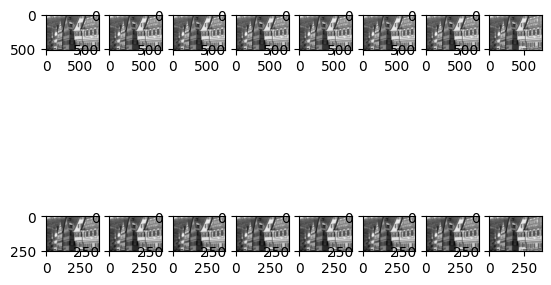

In [115]:
# Constructing 4 octaves for the image, and 5 
# blurring levels for each octave. 
num_octaves = 2
num_scales = 5
total_scales = num_scales + 3
scale_space = np.empty((num_octaves, total_scales), dtype=object)

for i in range(num_octaves):
    # Downsampling the image
    resized_img = cv2.resize(img, (int(img.shape[1] / 2**i), int(img.shape[0] / 2**i)))

    # Standard deviation
    sigma0 = 1.6 * (i + 1)
    factor = 2 ** (1/num_scales)
    sigma = [sigma0 * (factor ** _) for _ in range(total_scales)]

    # Kernel size starts at 3x3, goes up by 2 px each octave. 
    kernel_side = 3 + 2 * i
    for j in range(total_scales):
        blurred_img = cv2.GaussianBlur(resized_img, (kernel_side, kernel_side), sigma[j])
        scale_space[i][j] = blurred_img

fig, ax = plt.subplots(num_octaves, total_scales)

for i in range(num_octaves):
    for j in range(total_scales):
        ax[i][j].imshow(scale_space[i][j])


In [116]:
for i in range(num_octaves):
    # for j in range(total_scales):
    sigma0 = 1.6 * (i + 1)
    print(sigma0)
    factor = 2 ** (1/num_scales)
    print(factor)
    sigma = [sigma0 * (factor ** _) for _ in range(total_scales)]
    print(sigma)
    print()
        

1.6
1.148698354997035
[1.6, 1.8379173679952563, 2.111212657236631, 2.4251465064166378, 2.7857618025475985, 3.2000000000000015, 3.675834735990514, 4.222425314473265]

3.2
1.148698354997035
[3.2, 3.6758347359905126, 4.222425314473262, 4.8502930128332755, 5.571523605095197, 6.400000000000003, 7.351669471981028, 8.44485062894653]



In [94]:
scale_space.shape

(4, 6)

In [117]:
diff_of_gaussians = scale_space[:, :-1] - scale_space[:, 1:]
diff_of_gaussians.shape

(2, 7)

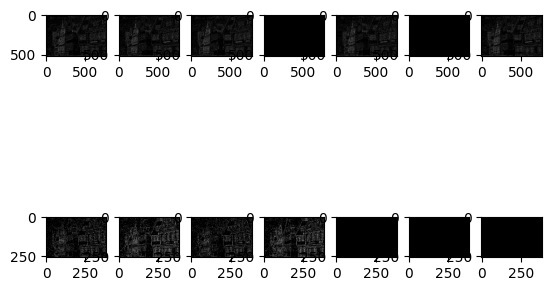

In [119]:
diff_of_gaussians = scale_space[:, :-1] - scale_space[:, 1:]

fig, ax = plt.subplots(num_octaves, total_scales - 1)

for i in range(num_octaves):
    for j in range(total_scales - 1):
        ax[i][j].imshow(diff_of_gaussians[i][j])

## Local Extrema Detection

In [34]:
diff_of_gaussians.shape, diff_of_gaussians[0, 0].shape

((4, 4), (512, 768))

In [45]:
temp = [[None] * num_scales for _ in range(num_octaves)]

for i in range(num_octaves):
    for j in range(num_scales):
        temp[i][j] = 1.6 * (2 ** ((i + j)/num_scales))

temp

[[1.6,
  1.8379173679952563,
  2.111212657236631,
  2.425146506416637,
  2.785761802547597],
 [1.8379173679952563,
  2.111212657236631,
  2.425146506416637,
  2.785761802547597,
  3.2],
 [2.111212657236631,
  2.425146506416637,
  2.785761802547597,
  3.2,
  3.6758347359905117],
 [2.425146506416637,
  2.785761802547597,
  3.2,
  3.6758347359905117,
  4.222425314473262]]

In [ ]:
@dataclass
class Keypoint:
    x: int
    y: int
    value: int
    octave: int
    scale: int
    sigma: float


extrema = []

for octave in range(1, diff_of_gaussians.shape[0] - 1):
    for scale in range(1, diff_of_gaussians.shape[0] - 1):
        prev_img = diff_of_gaussians[i, j-1]
        curr_img = diff_of_gaussians[i, j]
        next_img = diff_of_gaussians[i, j+1]

        height, width = curr_img.shape

        for y in range(0, height):
            for x in range(0, width):
                candidate_pixel = curr_img[y, x]

                neighborhood = [
                    prev_img[y:]
                ]

                neighborhood_max = np.max([])








(512, 768)

In [37]:
a = diff_of_gaussians[0, 0][200:203, 200:203]
b = diff_of_gaussians[0, 1][200:203, 200:203]
c = diff_of_gaussians[0, 2][200:203, 200:203]

a, b, c

(array([[  0, 254,   2],
        [254, 253,   3],
        [  0, 254,   2]], dtype=uint8),
 array([[  0, 255,   1],
        [  0, 255,   1],
        [255, 255,   1]], dtype=uint8),
 array([[  0, 255,   0],
        [255,   0,   0],
        [  0,   0,   0]], dtype=uint8))

In [39]:
np.min([a, b, c])

0

Using opencv for keypoint extraction

In [107]:
sift = cv2.SIFT.create()
keypoints = sift.detect(img, None)

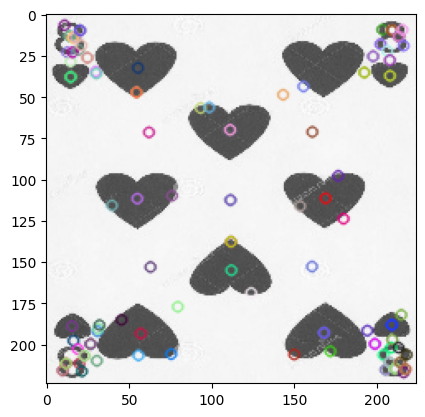

In [113]:
img = cv2.drawKeypoints(img, keypoints, img)
plt.imshow(img)